In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)
tf.set_random_seed(1)
raw_dataset = pd.read_csv("ANN_WP4.csv", 
                  sep=',', 
                  names=["alpha", "tu", "ts","EN"])
dataset = raw_dataset.copy()
#dataset=pd.concat([dataset.pop(x) for x in ["EN"]],1)
#print(dataset.shape)
dataset.tail()


C:\Users\HP\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\Anaconda3\envs\specialTopics\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\Anaconda3\envs\specialTopics\lib\site-packages

1.13.1


,alpha,tu,ts,EN
52,60.0,29.416598,-23.296639,0.050987
53,62.5,29.408689,-31.415927,0.081744
54,65.0,31.415927,-30.863802,0.222853
55,67.5,31.415927,-31.409498,0.428109
56,70.0,31.415927,-31.415927,0.613385


In [2]:
dataset.isna().sum()
dataset = dataset.dropna()
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

train_dataset = dataset.sample(frac=0.85,random_state=0)
train_dataset_temp = train_dataset
#print(train_dataset.index)
test_dataset = dataset.drop(train_dataset.index)
#print(test_dataset)


In [3]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats
#print(train_stats)

,count,mean,std,min,25%,50%,75%,max
alpha,48.0,-0.729167,39.332727,-67.500000,-33.125000,-1.250000,30.625000,70.000000
tu,48.0,17.103755,10.566318,0.588668,9.031782,16.672606,28.844809,31.415927
ts,48.0,-15.565194,9.500426,-31.415927,-23.568526,-13.814991,-8.758476,-0.452042
EN,48.0,0.085572,0.115122,0.015222,0.035030,0.055929,0.073994,0.613385


In [4]:
def norm(x):
    return (x - train_stats['min']) / (train_stats['max']-train_stats['min'])

normed_train_data = norm(train_dataset)

train_labels = pd.concat([normed_train_data.pop(x) for x in ["EN"]], 1)

#print(train_labels)
#print(normed_train_data)

In [5]:
normed_test_data = norm(test_dataset)

test_labels = pd.concat([normed_test_data.pop(x) for x in ["EN"]], 1)

#print(test_labels)
#print(normed_test_data)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(25, activation='exponential', input_shape=[3]),
    layers.Dense(50, activation='tanh'),
    layers.Dense(45, activation='exponential'),
    layers.Dense(1, activation='exponential')
  ])
#keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
#keras.optimizers.RMSprop(lr=0.001, rho=0.9)
  optimizer = tf.keras.optimizers.Nadam(lr=0.003, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_6 (Dense)              (None, 45)                2295      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 46        
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 10000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
9995,0.001390,0.011439,0.001390,0.012053,0.051907,0.012053,9995
9996,0.001336,0.011615,0.001336,0.011898,0.052451,0.011898,9996
9997,0.001263,0.011711,0.001263,0.011505,0.052767,0.011505,9997
9998,0.001177,0.011060,0.001177,0.011721,0.052440,0.011721,9998
9999,0.001121,0.011056,0.001121,0.012090,0.052375,0.012090,9999


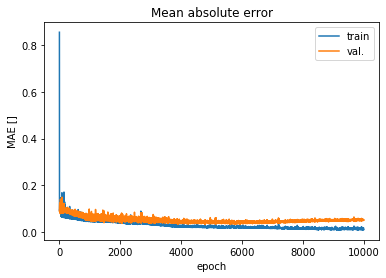

In [16]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
#plt.ylim([0,10])
plt.title('Mean absolute error')
plt.ylabel('MAE []')
plt.xlabel('epoch')
plt.legend(['train','val.'],loc='upper right')
plt.savefig('mae_epoch.png', dpi = 600)
plt.show()

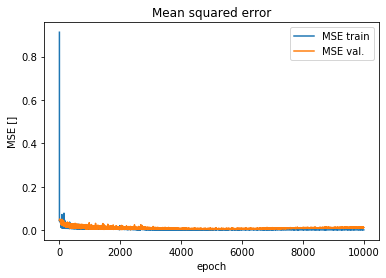

In [17]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
#plt.ylim([0,20])
plt.title('Mean squared error')
plt.ylabel('MSE []')
plt.xlabel('epoch')
plt.legend(['MSE train','MSE val.'],loc='upper right')
plt.savefig('mse_epoch.png', dpi = 600)
plt.show()

In [18]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} e".format(mae))


 - 0s - loss: 0.0848 - mean_absolute_error: 0.1735 - mean_squared_error: 0.0848
Testing set Mean Abs Error:  0.17 e


In [19]:
test_predictions = model.predict(normed_test_data)


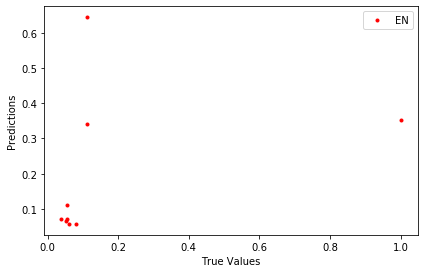

In [20]:
a = plt.axes(aspect='equal')
columns = ["EN"]
color = ["r."]
for i in range(1):    
    plt.plot(test_labels[columns[i]].to_numpy(), test_predictions[:,i], color[i], label = columns[i] )
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.tight_layout()
plt.savefig('Minimum Euclidean Norm', dpi = 600)
plt.show()

In [21]:
error = test_predictions - test_labels
print(error)

          EN
0  -0.648096
3   0.228425
9   0.057934
19  0.033758
39 -0.024929
44  0.014149
47  0.017900
52 -0.002640
53  0.533907
